# Retention Update Scores
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Mar 18, 2022

In [51]:
import awswrangler as wr
import boto3
import getpass
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from pytz import timezone
from pycaret.classification import *

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ····················


In [3]:
lkupclientid = 7
dbname = "stlrCanucks"

cursor = CNXN.cursor()

storedProc = (
    f"""Exec {dbname}.[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(32946, 54)

### We should specify the features used in our model:

In [4]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "lkupClientId",
    "productGrouping",
    "recency",
    "recentDate",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (23643, 11)
Unseen Data For Predictions: (4172, 11)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [5]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimCustomerMasterId",
        "lkupClientId",
        "productGrouping",
        "recentDate",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [20]:
model_matrix = compare_models(
    fold= 10,
    include= ["xgboost"],
    probability_threshold= 0.75
)

final_model = finalize_model(model_matrix)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7177,0.8613,0.5260,0.8816,0.6588,0.4432,0.4865,0.3290


### Let's load in our 2021 season data and get retention scores using the model:

In [21]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(5131, 11)

### Let's run the new season data through our model to get retention score predictions:

In [9]:
df_predictions = (predict_model(final_model, data=df_inference, raw_score=True))
df_predictions = df_predictions[df_predictions["Score_1"] >= 0.025]

### We can create some histograms to visualize each model distribution:

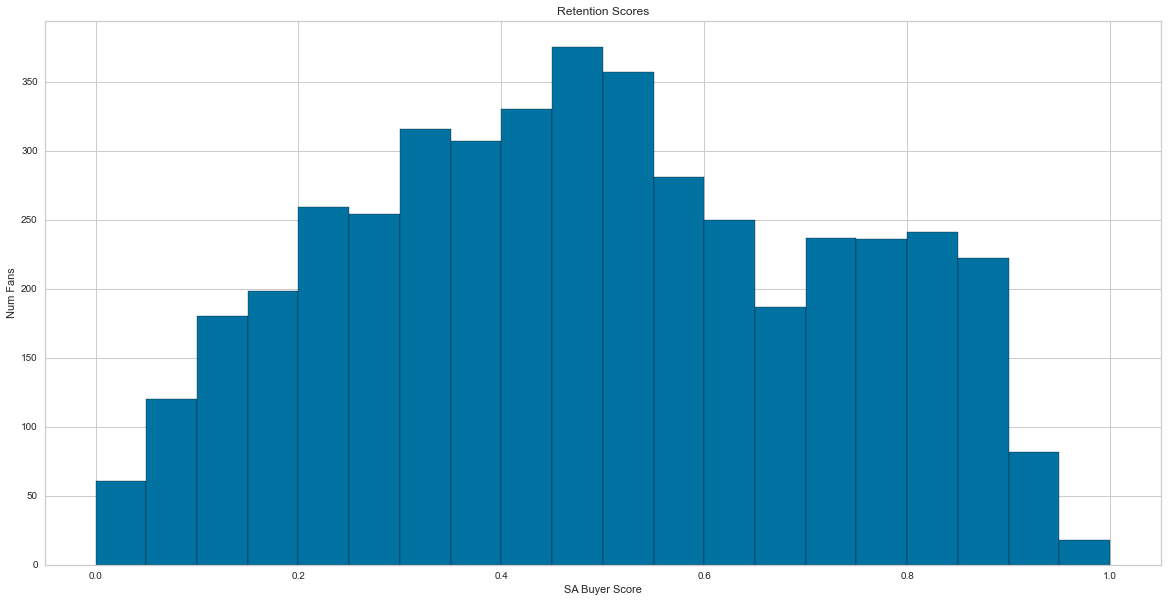

In [44]:
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.hist(df_predictions["Score_1"], bins=20, edgecolor="black", range=(0,1))
plt.rcParams["figure.figsize"] = (20,10)
                            
plt.show()

### We can also see how many purchases there are in each range of scores:

In [60]:
df_predictions["Score_1"].value_counts(bins=np.arange(0, 1.05, 0.05)).sort_index(ascending=False)

(0.95, 1.0]        18
(0.9, 0.95]        82
(0.85, 0.9]       222
(0.8, 0.85]       241
(0.75, 0.8]       236
(0.7, 0.75]       237
(0.65, 0.7]       186
(0.6, 0.65]       251
(0.55, 0.6]       281
(0.5, 0.55]       357
(0.45, 0.5]       375
(0.4, 0.45]       330
(0.35, 0.4]       307
(0.3, 0.35]       316
(0.25, 0.3]       254
(0.2, 0.25]       259
(0.15, 0.2]       198
(0.1, 0.15]       180
(0.05, 0.1]       120
(-0.001, 0.05]     61
Name: Score_1, dtype: int64

### First we have to tell AWS which profile we'd like to login to, this will send us for a browser authentication trip:

In [61]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

SSVQ-BWBT
Successully logged into Start URL: https://stellaralgo.awsapps.com/start


### Now we can create a session and client to RedShift, and create a new connection using AWS wrangler:

In [80]:
session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')
client = boto3.client('redshift')
    
conn = wr.data_api.redshift.connect(
    cluster_id = "qa-app",
    database = {dbname},
    db_user = "admin"
)

print("CREDENTIALS RETRIEVED SUCCESSFULLY")

CREDENTIALS RETRIEVED SUCCESSFULLY


### Insert the new scores into the RedShift customerretentionscores table:

In [79]:
print("INSERTING NEW RETENTION SCORES TO DB")

fields = f"""
INSERT INTO {dbname}.dw.customerretentionscores (
    attendancePercentage,
    currversnflag,
    dimcustomermasterid,
    insertdate,
    lkupclientid,
    mostrecentattendance,
    product,
    sascore,
    seasonYear,
    tenuredays
) VALUES """

values_list = []
for i, (index, row) in enumerate(df_predictions.iterrows()):

    values = f"""
        (
            {str(row.attendancePercent)},
            {str(0)},
            {str(row.dimCustomerMasterId)},
            '{str(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))}',
            {str(lkupclientid)},
            '{str(row.recentDate)}',
            '{str(row.productGrouping)}',
            {str(round(row.Score_1,4))},
            {str(row.year)},
            {str(row.source_tenure)}
        )"""

    values_list.append(values)

    batch_size = 250
    if(i%batch_size == 0):
        insert_statement = fields + ",".join(values_list)+";"

        wr.data_api.redshift.read_sql_query(
            sql = insert_statement, 
            con = conn
        )
        
        values_list = []       
        print(f" > ROWS: {i+1}-{i+batch_size} | {round(100*(i+1)/len(df_predictions),0)}% COMPLETED")

print("RETENTION SCORE INSERTS COMPLETED")

INSERTING NEW RETENTION SCORES TO DB
 > ROWS: 1-250 | 0.0% COMPLETED
 > ROWS: 251-500 | 6.0% COMPLETED
 > ROWS: 501-750 | 11.0% COMPLETED
 > ROWS: 751-1000 | 17.0% COMPLETED
 > ROWS: 1001-1250 | 22.0% COMPLETED
 > ROWS: 1251-1500 | 28.0% COMPLETED
 > ROWS: 1501-1750 | 33.0% COMPLETED
 > ROWS: 1751-2000 | 39.0% COMPLETED
 > ROWS: 2001-2250 | 44.0% COMPLETED
 > ROWS: 2251-2500 | 50.0% COMPLETED
 > ROWS: 2501-2750 | 55.0% COMPLETED
 > ROWS: 2751-3000 | 61.0% COMPLETED
 > ROWS: 3001-3250 | 67.0% COMPLETED
 > ROWS: 3251-3500 | 72.0% COMPLETED
 > ROWS: 3501-3750 | 78.0% COMPLETED
 > ROWS: 3751-4000 | 83.0% COMPLETED
 > ROWS: 4001-4250 | 89.0% COMPLETED
 > ROWS: 4251-4500 | 94.0% COMPLETED
 > ROWS: 4501-4750 | 100.0% COMPLETED
RETENTION SCORE INSERTS COMPLETED


### Let's query RedShift to make sure our records got into the database:

In [77]:
select_statement = f"""
    SELECT *
    FROM {dbname}.dw.customerretentionscores
"""

df_scores = wr.data_api.redshift.read_sql_query(
    sql = select_statement, 
    con = conn
)

print(f"TOTAL RECORDS: {df_scores.shape[0]}")
df_scores.head()

TOTAL RECORDS: 4501


,customerretentionscoreid,dimcustomermasterid,lkupclientid,currversnflag,seasonyear,insertdate,sascore,mostrecentattendance,attendancepercentage,tenuredays,product
0,100488,134957,7,false,2021,2022-03-18 10:16:01,0.8373,2022-03-13 00:00:00,0.875000,11680,Full Season
1,100492,135658,7,false,2021,2022-03-18 10:16:01,0.5022,2022-03-09 00:00:00,1.000000,1460,Quarter
2,100496,136431,7,false,2021,2022-03-18 10:16:01,0.4559,2022-03-15 00:00:00,0.937500,12410,Full Season
3,100500,136607,7,false,2021,2022-03-18 10:16:01,0.3740,2022-03-13 00:00:00,0.750000,6935,Full Season
4,100504,136761,7,false,2021,2022-03-18 10:16:01,0.5421,2022-03-15 00:00:00,0.791667,6205,Full Season


### We can also use the API to delete records from the database:

In [78]:
delete_statement = f"""
    DELETE 
    FROM {dbname}.dw.customerretentionscores
    WHERE lkupclientid = {lkupclientid}
"""

df_table = wr.data_api.redshift.read_sql_query(
    sql = delete_statement, 
    con = conn
)

df_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame